In [208]:
import os
import random
import shutil
import time
import warnings
import pandas as pd
import numpy as np
import cv2
from PIL import Image
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim

from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import timm
from timm import create_model

In [18]:
parquet_path = '/Users/cjdonahoe/github/cellvit/treatment_labels.parquet'
df = pd.read_parquet(parquet_path)
df.head()

,Collection,Metadata_Plate,Metadata_Well,Metadata_Site,Treatment,Treatment_Type,Control,LeaveReplicatesOut,LeaveCellsOut
0,BBBC036,24277,a06,1,BRD-K18619710,Compound,Treatment,Training,Validation
1,BBBC036,24277,a06,1,BRD-K18619710,Compound,Treatment,Training,Training
2,BBBC036,24277,a06,1,BRD-K18619710,Compound,Treatment,Training,Training
3,BBBC036,24277,a06,1,BRD-K18619710,Compound,Treatment,Training,Training
4,BBBC036,24277,a06,1,BRD-K18619710,Compound,Treatment,Training,Validation


In [23]:
df['image_key'] = df['Collection'].map(str) + '-' + df['Metadata_Plate'].map(str) + '-' + df['Metadata_Well'].map(str)
df.head()

,Collection,Metadata_Plate,Metadata_Well,Metadata_Site,Treatment,Treatment_Type,Control,LeaveReplicatesOut,LeaveCellsOut,image_key
0,BBBC036,24277,a06,1,BRD-K18619710,Compound,Treatment,Training,Validation,BBBC036-24277-a06
1,BBBC036,24277,a06,1,BRD-K18619710,Compound,Treatment,Training,Training,BBBC036-24277-a06
2,BBBC036,24277,a06,1,BRD-K18619710,Compound,Treatment,Training,Training,BBBC036-24277-a06
3,BBBC036,24277,a06,1,BRD-K18619710,Compound,Treatment,Training,Training,BBBC036-24277-a06
4,BBBC036,24277,a06,1,BRD-K18619710,Compound,Treatment,Training,Validation,BBBC036-24277-a06


In [25]:
metadata_df = pd.read_csv("/Users/cjdonahoe/Documents/personal/ucb-mids/210-capstone/cellpainting-gallery/cpg0019-moshkov-deepprofiler/broad/workspace_dl/metadata/sc-metadata.csv",
      dtype={
                "Collection": str,
                "Metadata_Plate": str,
                "Metadata_Well": str,
                "Metadata_Site": str,
                "Image_Name": str,
                "Treatment": str,
                "Treatment_Type": str,
                "Control": str,
                "Cell_line": str,
                "LeaveReplicatesOut": str,
                "LeaveCellsOut": str,
            },
        )
metadata_df["PathId"] = metadata_df.apply(
            lambda x: x["Image_Name"].split("/")[-1], axis=1
        )

metadata_df.to_parquet("/Users/cjdonahoe/github/cellvit/metadata.parquet")

In [26]:
metadata_parquet_df = pd.read_parquet("/Users/cjdonahoe/github/cellvit/metadata.parquet")

In [ ]:
BBBC037_path = "/Users/cjdonahoe/Documents/personal/ucb-mids/210-capstone/cellpainting-gallery/cpg0019-moshkov-deepprofiler/broad/training_images/BBBC037/"

In [50]:
print(metadata_parquet_df[['Image_Name', 'Treatment']].head(5))

for index, row in metadata_parquet_df.head(5).iterrows():
    print(type(row['Image_Name']))
    substr_raw = row['Image_Name'][21:]
    print(substr_raw)

                                          Image_Name      Treatment
0  ../../training_images/BBBC036/24277/a06/1/976@...  BRD-K18619710
1  ../../training_images/BBBC036/24277/a06/1/976@...  BRD-K18619710
2  ../../training_images/BBBC036/24277/a06/1/976@...  BRD-K18619710
3  ../../training_images/BBBC036/24277/a06/1/976@...  BRD-K18619710
4  ../../training_images/BBBC036/24277/a06/1/976@...  BRD-K18619710
<class 'str'>
/BBBC036/24277/a06/1/976@86x17.png
<class 'str'>
/BBBC036/24277/a06/1/976@167x29.png
<class 'str'>
/BBBC036/24277/a06/1/976@26x104.png
<class 'str'>
/BBBC036/24277/a06/1/976@140x149.png
<class 'str'>
/BBBC036/24277/a06/1/976@543x197.png


In [58]:
def copy_and_rename_img(collection: str):
  root_path = "/Users/cjdonahoe/Documents/personal/ucb-mids/210-capstone/cellpainting-gallery/cpg0019-moshkov-deepprofiler/broad/training_images/"
  single_collection_df = metadata_parquet_df[metadata_parquet_df['Collection'] == collection]
  for index, row in single_collection_df.iterrows():
      src = root_path + row['Image_Name'][22:]
      if not os.path.exists(root_path + collection + "/" + row['Treatment']):
          os.makedirs(root_path + collection + "/" + row['Treatment'])
      dst = root_path + collection + "/" + row['Treatment'] + "/" + row['Metadata_Plate'] + "_" + row['Metadata_Well'] + "_" + row['Metadata_Site'] + "_" + row['PathId']
      shutil.copy(src, dst)
  return

In [59]:
copy_and_rename_img('BBBC037')

In [ ]:
'''
torchvision.datasets.ImageFolder
https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html

root/dog/xxx.png
root/dog/xxy.png
root/dog/[...]/xxz.png

root/cat/123.png
root/cat/nsdf3.png
root/cat/[...]/asd932_.png'''


In [66]:
metadata_parquet_df[metadata_parquet_df['Image_Name'].str.contains('/41756/e10/')]

,Collection,Metadata_Plate,Metadata_Well,Metadata_Site,Nuclei_Location_Center_X,Nuclei_Location_Center_Y,Image_Name,Treatment,Treatment_Type,Control,Cell_line,LeaveReplicatesOut,LeaveCellsOut,PathId
8339113,BBBC037,41756,e10,1,758,33,../../training_images/BBBC037/41756/e10/1/77@7...,CSNK1E_WT,ORF,Treatment,U2OS,NotUsed,NotUsed,77@758x33.png
8339114,BBBC037,41756,e10,1,400,51,../../training_images/BBBC037/41756/e10/1/77@4...,CSNK1E_WT,ORF,Treatment,U2OS,NotUsed,Training,77@400x51.png
8339115,BBBC037,41756,e10,1,381,61,../../training_images/BBBC037/41756/e10/1/77@3...,CSNK1E_WT,ORF,Treatment,U2OS,NotUsed,Training,77@381x61.png
8339116,BBBC037,41756,e10,1,554,78,../../training_images/BBBC037/41756/e10/1/77@5...,CSNK1E_WT,ORF,Treatment,U2OS,Validation,NotUsed,77@554x78.png
8339117,BBBC037,41756,e10,1,729,87,../../training_images/BBBC037/41756/e10/1/77@7...,CSNK1E_WT,ORF,Treatment,U2OS,NotUsed,Training,77@729x87.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8339740,BBBC037,41756,e10,9,671,1027,../../training_images/BBBC037/41756/e10/9/77@6...,CSNK1E_WT,ORF,Treatment,U2OS,NotUsed,Training,77@671x1027.png
8339741,BBBC037,41756,e10,9,790,1029,../../training_images/BBBC037/41756/e10/9/77@7...,CSNK1E_WT,ORF,Treatment,U2OS,NotUsed,NotUsed,77@790x1029.png
8339742,BBBC037,41756,e10,9,1035,1051,../../training_images/BBBC037/41756/e10/9/77@1...,CSNK1E_WT,ORF,Treatment,U2OS,NotUsed,Training,77@1035x1051.png
8339743,BBBC037,41756,e10,9,555,1052,../../training_images/BBBC037/41756/e10/9/77@5...,CSNK1E_WT,ORF,Treatment,U2OS,NotUsed,NotUsed,77@555x1052.png


In [68]:
# read in the image
img_path = '/Users/cjdonahoe/Documents/personal/ucb-mids/210-capstone/cellpainting-gallery/cpg0019-moshkov-deepprofiler/broad/training_images/BBBC037/_output/train/AKT1_E17K/41754_d16_2_6@89x508.png'
raw_image = cv2.imread(img_path)

In [211]:
img_path = '/Users/cjdonahoe/Documents/personal/ucb-mids/210-capstone/cellpainting-gallery/cpg0019-moshkov-deepprofiler/broad/training_images/BBBC037/_output/'
os.listdir(img_path)

['.DS_Store', 'test', 'train', 'val']

In [204]:
def convert_img_to_5_channel_tensor(img_path: str, square_size:int, image_size: int):
  # convert image to numpy ndarray
  raw_image = np.array(img_path)
  # remove redundant channels and the 6th channel (i.e. last square of the raw image)
  trimmed_image = raw_image[:, :-square_size, 0]
  # convert to RGB
  resized_image = cv2.resize(trimmed_image, (image_size*5, image_size))
  # split the image into the 5 fluorescent channels
  split_image = np.array(np.hsplit(resized_image, 5))
  # convert to tensor and normalize to 0-1 range
  five_channel_tensor = (torch.from_numpy(split_image))/255
  # split the image into the 5 fluorescent channels
  return five_channel_tensor

def load_images_from_folder(folder, square_size, image_size):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(convert_img_to_5_channel_tensor(img, square_size, image_size))
    return images

In [205]:
x=convert_img_to_5_channel_tensor(
  '/Users/cjdonahoe/Documents/personal/ucb-mids/210-capstone/cellpainting-gallery/cpg0019-moshkov-deepprofiler/broad/training_images/BBBC037/_output/train/AKT1_E17K/41754_d16_2_6@89x508.png',
  160,
  224
)

<class 'numpy.ndarray'>


In [ ]:
class To5ChannelCellPaintingTensor(object):
    """Convert images in Pytorch Dataset to Tensors with one channel
    for each discrete fluerecent image in a Cell Painting sample."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

In [192]:
x_train_dataset = torchvision.datasets.ImageFolder('/Users/cjdonahoe/Documents/personal/ucb-mids/210-capstone/cellpainting-gallery/cpg0019-moshkov-deepprofiler/broad/training_images/BBBC037/_output/train/')

In [207]:
np.array(x_train_dataset[34098][0]).shape

(160, 960, 3)

raw image shape: (160, 960, 3).
raw_image dtype: <class 'numpy.ndarray'>

gray resized image shape: (224, 1120).
gray_image_resized dtype: <class 'numpy.ndarray'>



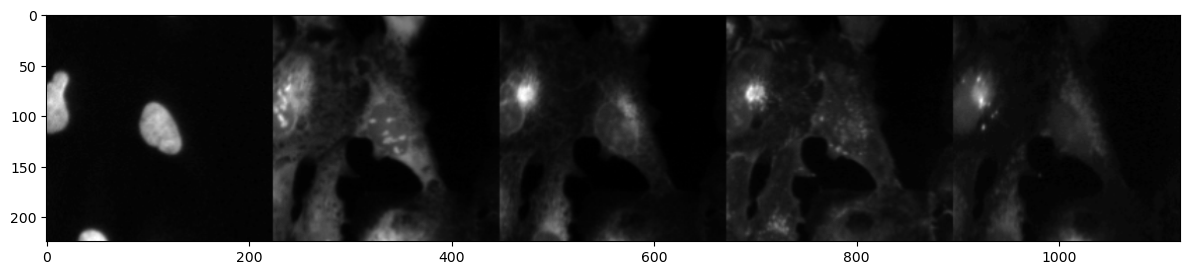

hello


In [72]:
# calculate the square size of the raw image assuming it is a 1x6 grid
# square_size = int(len(raw_image[0,:])/6)
square_size = 160



# resize to match the expected input size of the model
image_size = 224
gray_image_resized = cv2.resize(gray_image, (image_size*5, image_size))

# display the image
# set the figure size
plt.rcParams["figure.figsize"] = [12.00, 3.50]
plt.rcParams["figure.autolayout"] = True

# plot the data using imshow with gray colormap
plt.imshow(gray_image_resized, cmap='gray')

print(f"raw image shape: {raw_image.shape}.\nraw_image dtype: {type(raw_image)}\n")
print(f"gray resized image shape: {gray_image_resized.shape}.\ngray_image_resized dtype: {type(gray_image_resized)}\n")

# display the plot
plt.show()


<class 'torch.Tensor'>
The image is now a tensor with shape: torch.Size([5, 224, 224])



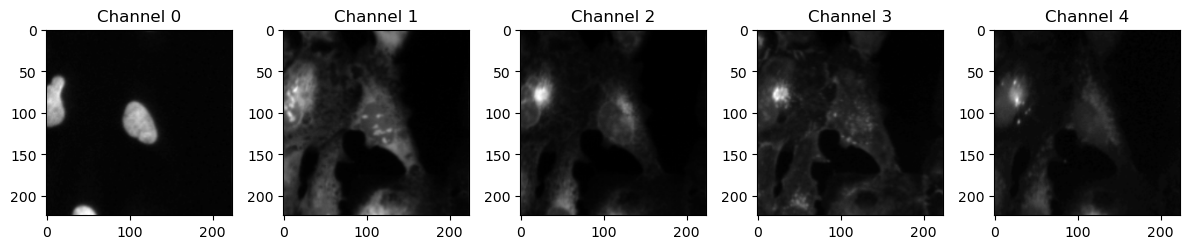

In [95]:
# set the example image
example_image = gray_image_resized

# split the image into the 5 fluorescent channels
example_image = np.array(np.hsplit(example_image, 5))

# convert the array to a tensor
example_image_tensor = torch.tensor(example_image)
print(type(example_image_tensor[0,0,0]))

print(f"The image is now a tensor with shape: {example_image_tensor.shape}\n")

# display each fluorescent channel as a discrete image
fig, axs = plt.subplots(nrows=1, ncols=5)

axs_int = 0
for i in range(5):
  image = example_image_tensor[i,:,:]
  axs[axs_int].imshow(image, cmap='gray')
  axs[axs_int].set_title(f"Channel {i}")
  axs_int += 1
plt.show()

Text(0.5, 1.0, 'distribution of pixels')

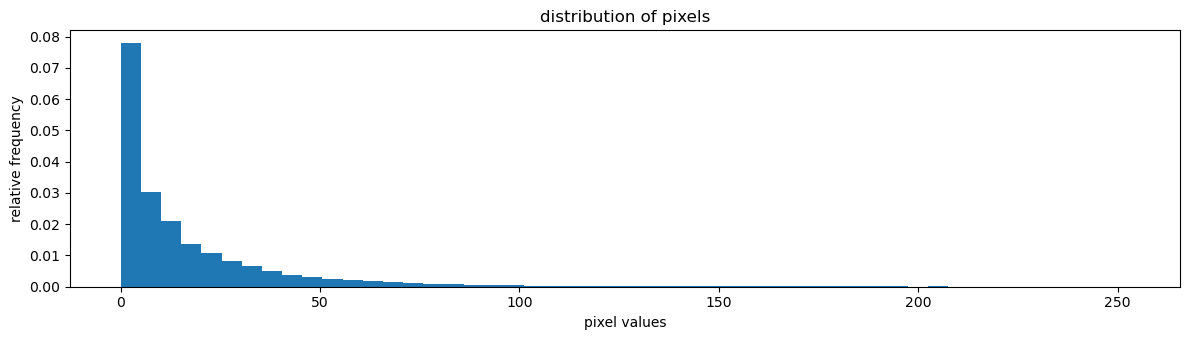

In [81]:
plt.hist(example_image.ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")

In [84]:
example_image_tensor/255

tensor([[[0.0275, 0.0275, 0.0275,  ..., 0.0157, 0.0157, 0.0235],
         [0.0235, 0.0275, 0.0275,  ..., 0.0196, 0.0157, 0.0235],
         [0.0196, 0.0235, 0.0235,  ..., 0.0196, 0.0157, 0.0275],
         ...,
         [0.0275, 0.0314, 0.0275,  ..., 0.0157, 0.0157, 0.0392],
         [0.0275, 0.0275, 0.0235,  ..., 0.0157, 0.0157, 0.0392],
         [0.0235, 0.0235, 0.0196,  ..., 0.0157, 0.0157, 0.0392]],

        [[0.0706, 0.0706, 0.0627,  ..., 0.0000, 0.0039, 0.0157],
         [0.0667, 0.0667, 0.0549,  ..., 0.0000, 0.0039, 0.0118],
         [0.0627, 0.0588, 0.0471,  ..., 0.0000, 0.0039, 0.0118],
         ...,
         [0.1490, 0.1804, 0.1765,  ..., 0.0275, 0.0314, 0.0431],
         [0.1490, 0.1765, 0.1765,  ..., 0.0314, 0.0314, 0.0471],
         [0.1451, 0.1686, 0.1686,  ..., 0.0353, 0.0353, 0.0510]],

        [[0.0314, 0.0314, 0.0314,  ..., 0.0000, 0.0039, 0.0196],
         [0.0314, 0.0353, 0.0353,  ..., 0.0000, 0.0039, 0.0157],
         [0.0314, 0.0353, 0.0353,  ..., 0.0000, 0.0039, 0.